In [4]:
#import all libraries needed. We can remove many of them
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

import numpy as np
np.random.seed(1338) # for reproducibility
import pandas as pd
import _pickle as cPickle
from collections import defaultdict
import re
import sys

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


from keras.layers import Dense, Input, Flatten
#from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, concatenate
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import optimizers
from keras import regularizers
from keras.utils.layer_utils import print_summary
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from keras.activations import softmax
import os

#from keras import initializations


from bs4 import BeautifulSoup
from keras import backend as K
# K.clear_session()

#libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
import os

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, Input, Flatten, Reshape
#from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, Concatenate, GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model, Sequential
from keras.utils import to_categorical

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import optimizers
from keras import regularizers
from keras.utils.layer_utils import print_summary
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
import warnings


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [51]:
img_size = 256
batch_size = 16
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

#Sett=1
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100

#Measure of success
def kappa(y_true, y_pred):
    y_true = np.argmax(y_true, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [52]:
breeds = pd.read_csv('../all/breed_labels.csv')
colors = pd.read_csv('../all/color_labels.csv')
states = pd.read_csv('../all/state_labels.csv')
train = pd.read_csv('../all/train.csv')
test = pd.read_csv('../all/test/test.csv')

In [53]:
pet_ids = train['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

#Extract text features

In [54]:
def clean_str(df):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = df['Description']
    string = re.sub(r"\\", "", string)    
    #string = re.sub(r"\'", "", string)    #this will remove ' 
    string = re.sub(r"\"", "", string)
    string = re.sub("<a.*?</a>", "", string) #remobe <a> href tag
    return string.strip().lower()

def preprocess(text):
    """
    Preparing text and labels
    """
    texts = []
    
    for idx in range(text.shape[0]):
        text = df.Text[idx]
        texts.append(clean_str(text))
    
    return texts

def tokenization(texts,dataset= "full_data", maxlen=MAX_SEQUENCE_LENGTH,num_words=MAX_NB_WORDS):
    ### tokenizing and creating word_index dictionary - Map each word to and index in vocabulary dictionary

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts) #only keep top 20000

    word_index = tokenizer.word_index # all unique word index!
    print('Found {} unique tokens in {}.'.format(len(word_index),dataset))

    data2 = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #pad all sequences to be size 1000
    
    return sequences, word_index, data2

In [55]:
train = train.fillna("")
test = test.fillna("")

train['Description'] = train.apply(clean_str, axis = 1)
test['Description'] = test.apply(clean_str, axis = 1)

In [56]:
seq , word_index , full_data = tokenization(train.Description)
test_seq , test_word_index , test_full_data = tokenization(test.Description)

Found 21810 unique tokens in full_data.
Found 11547 unique tokens in full_data.


In [57]:
full_data.shape

(14993, 1000)

In [58]:
def create_embedding(dic, word_embed):
    embedin_matrix = np.random.random((len(dic) + 1 , EMBEDDING_DIM))
    for word, ind in dic.items():
        embedding_vector = word_embed.get(word)
        if embedding_vector is not None:
            embedin_matrix[ind] = embedding_vector ### word not found in glove will be initialized randomly
    
    return embedin_matrix

In [59]:
import sys
import os

GLOVE_DIR = "../all/data/glove"

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

em_mat = create_embedding(word_index, embeddings_index)
#test_em_mat = create_embedding(test_word_index, embeddings_index)


In [60]:
#create the keras embedding layer which we will use for all our experiments
embedding_layer = Embedding(len(em_mat),
                            EMBEDDING_DIM,
                            weights=[em_mat],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Get 256 image features for each pet

Don't need to run the model now. Directly load the csv features. Later, we could use a different pre-trained model or even re-train few layers.

In [205]:
# def resize_to_square(im):
#     old_size = im.shape[:2] # old_size is in (height, width) format
#     ratio = float(img_size)/max(old_size)
#     new_size = tuple([int(x*ratio) for x in old_size])
#     # new_size should be in (width, height) format
#     im = cv2.resize(im, (new_size[1], new_size[0]))
#     delta_w = img_size - new_size[1]
#     delta_h = img_size - new_size[0]
#     top, bottom = delta_h//2, delta_h-(delta_h//2)
#     left, right = delta_w//2, delta_w-(delta_w//2)
#     color = [0, 0, 0]
#     new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
#     return new_im

# def load_image(path, pet_id):
#     image = cv2.imread(f'{path}{pet_id}-1.jpg')
#     new_image = resize_to_square(image)
#     new_image = preprocess_input(new_image)
#     return new_image

# inp = Input((256,256,3))
# backbone = DenseNet121(input_tensor = inp, include_top = False)
# x = backbone.output
# x = GlobalAveragePooling2D()(x)
# x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
# x = AveragePooling1D(4)(x)
# out = Lambda(lambda x: x[:,:,0])(x)

# m = Model(inp,out)

# features = {}
# for b in (range(n_batches)):
#     start = b*batch_size
#     end = (b+1)*batch_size
#     batch_pets = pet_ids[start:end]
#     batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
#     for i,pet_id in enumerate(batch_pets):
#         try:
#             batch_images[i] = load_image("all/train_images/", pet_id)
#         except:
#             pass
#     batch_preds = m.predict(batch_images)
#     for i,pet_id in enumerate(batch_pets):
#         features[pet_id] = batch_preds[i]

# train_feats = pd.DataFrame.from_dict(features, orient='index')

# train_feats.to_csv('test_feats = pd.DataFrame.from_dict(features, orient='index')
# test_feats.to_csv('all/test/test_img_features.csv').csv')

# test_df = pd.read_csv('all/test/test.csv')
# pet_ids = test_df['PetID'].values
# n_batches = len(pet_ids) // batch_size + 1

# features = {}
# for b in tqdm_notebook(range(n_batches)):
#     start = b*batch_size
#     end = (b+1)*batch_size
#     batch_pets = pet_ids[start:end]
#     batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
#     for i,pet_id in enumerate(batch_pets):
#         try:
#             batch_images[i] = load_image("all/test_images/", pet_id)
#         except:
#             pass
#     batch_preds = m.predict(batch_images)
#     for i,pet_id in enumerate(batch_pets):
#         features[pet_id] = batch_preds[i]

# test_feats = pd.DataFrame.from_dict(features, orient='index')
# test_feats.to_csv('all/test/test_img_features.csv')

In [61]:
train_feats = pd.read_csv('../all/train_img_features.csv')
test_feats = pd.read_csv('../all/test/test_img_features.csv')

In [62]:
print(train_feats.shape)
print(test_feats.shape)

(14993, 257)
(3948, 257)


In [7]:
#df = train_feats.iloc[:, 1:]
#train_feats = train_feats.drop(train_feats.columns[1:], axis = 1)
#train_feats['Img_data'] = df.apply(lambda x: np.array(x), axis=1)
#train_feats['Img_data'] = df.apply(lambda x: x.tolist(), axis=1)

#### Merge the image features with the categorical and numerical embeddings

In [63]:
train = train.merge(train_feats, left_on='PetID', right_on='Unnamed: 0', how='outer')
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,246,247,248,249,250,251,252,253,254,255
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.787699,0.176625,0.575706,1.088627,0.439557,0.520460,1.547071,0.832572,0.599095,0.763349
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0.628260,0.686865,0.563999,0.968190,1.070276,1.545739,0.894411,0.838595,0.468236,0.916672
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.579116,0.557624,1.131405,0.720514,1.496672,0.870955,1.289682,1.184461,0.465113,0.892826
3,1,Miko,4,307,0,2,1,2,0,2,...,1.295853,0.326143,0.291668,1.608086,1.119176,1.470888,0.591445,0.832753,0.483021,1.134128
4,1,Hunter,1,307,0,1,1,0,0,2,...,1.092663,0.669893,0.395784,0.886075,1.219730,1.033964,1.065685,0.304053,0.438069,0.676818


In [64]:
train = pd.concat([train, pd.DataFrame(full_data)], axis=1, sort=False)
test = pd.concat([test, pd.DataFrame(test_full_data)], axis=1, sort=False)


### Encode tabular features

In [65]:
train_label = train.AdoptionSpeed
#We drop name because it creates a huge embedding vector and we know that name is not very useful anyway
train = train.drop(['AdoptionSpeed', 'Name', 'Description', 'PetID', 'Unnamed: 0', 'RescuerID'], axis=1)

In [66]:
train.shape

(14993, 1275)

In [67]:
#create train and test set
X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=TEST_SPLIT, random_state=9)

#Turn labels into n dimensional vectors for loss calculation
y_train = to_categorical(y_train, num_classes=None)
y_test = to_categorical(y_test, num_classes=None)

In [68]:
categorical_vars = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
        'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
        'Sterilized', 'Health', 'State']
numerical_vars = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']

In [69]:
def preproc(X_train, X_test, embed_cols, num_cols):

    input_list_train = []
    input_list_test = []
    m= MinMaxScaler()
        
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        m.fit(X_train[c].map(val_map).values.reshape(-1, 1))
        input_list_train.append(m.transform(X_train[c].map(val_map).values.reshape(-1, 1)))
        
        m.fit(X_test[c].map(val_map).fillna(0).values.reshape(-1, 1))
        input_list_test.append(m.transform(X_test[c].map(val_map).fillna(0).values.reshape(-1, 1)))
        
    #the numerical columns
    m.fit(X_train[num_cols].values)
    input_list_train.append(m.transform(X_train[num_cols].values))
    
    m.fit(X_test[num_cols].values)
    input_list_test.append(m.transform(X_test[num_cols].values))
    
    #img data
    input_list_train.append(X_train.iloc[:, 19:275].as_matrix())
    input_list_test.append(X_test.iloc[:, 19:275].as_matrix())
    
    #text data
    input_list_train.append(X_train.iloc[:, 275:].as_matrix())
    input_list_test.append(X_test.iloc[:, 275:].as_matrix())
    
    return input_list_train, input_list_test


#Creating a Embedding model for categorical variables using the fast.ai approach
def createModel(data, categorical_vars, numerical_vars):
    embeddings = []
    inputs = []
    for categorical_var in categorical_vars :
        i = Input(shape=(1,))
        model = Sequential()
        no_of_unique_cat  = data[categorical_var].nunique()
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
        embedding_size = int(embedding_size)
        vocab  = no_of_unique_cat+1
        embedding = Embedding(vocab ,embedding_size, input_length = 1 )(i)
        embedding = Reshape(target_shape=(embedding_size,))(embedding)
        embeddings.append( embedding )
        inputs.append(i)
        
    input_numeric = Input(shape=(len(numerical_vars),))
    embedding_numeric = Dense(16)(input_numeric) 
    
    
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    
    x = Concatenate()(embeddings)
    x = Dense(40, activation='relu')(x)
    x = Dropout(.25)(x)
    
    #hardcoded for now
    image_input = Input(shape=(256,))
    inputs.append(image_input)
    
    y = Dense(40, activation='relu')(image_input)    
    y = Dropout(.25)(y)
    
    #Words
    w = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    inputs.append(w)
    w = embedding_layer(w)
    w = Bidirectional(LSTM(20, recurrent_dropout=0.3))(w)
    
    z = Concatenate()([x, y, w])
    
    z = Dense(20, activation='relu')(z)
    z = Dense(10, activation='relu')(z)
    
    output = Dense(5, activation='softmax')(z)

    model = Model(inputs, output)
    model.compile(metrics=['categorical_accuracy'], loss='categorical_crossentropy', optimizer='adam')
    return model

In [70]:
warnings.filterwarnings('ignore')
X_train, X_test = preproc(X_train, X_test, categorical_vars, numerical_vars)

In [71]:
model = createModel(train, categorical_vars, numerical_vars)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_55 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_56 (

### Now, we will train our model

In [72]:
filepath="../checkpoints/weights_image_text_categorical.hdf6"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.0001, patience=4, verbose=0, mode='max')
#callbacks_list = [checkpoint, earlystopped]
callbacks_list = [checkpoint, earlystopped]



In [73]:
hist = model.fit(X_train, y_train, batch_size=64 ,epochs=15, validation_split=VALIDATION_SPLIT, 
                 shuffle=True, callbacks=callbacks_list)

Train on 10794 samples, validate on 2699 samples
Epoch 1/15
10794/10794 [==============================] - 514s 48ms/step - loss: 1.4724 - categorical_accuracy: 0.2783 - val_loss: 1.4424 - val_categorical_accuracy: 0.3112

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31123, saving model to ../checkpoints/weights_image_text_categorical.hdf6
Epoch 2/15
10794/10794 [==============================] - 508s 47ms/step - loss: 1.4279 - categorical_accuracy: 0.3298 - val_loss: 1.4197 - val_categorical_accuracy: 0.3649

Epoch 00002: val_categorical_accuracy improved from 0.31123 to 0.36495, saving model to ../checkpoints/weights_image_text_categorical.hdf6
Epoch 3/15
10794/10794 [==============================] - 486s 45ms/step - loss: 1.4034 - categorical_accuracy: 0.3598 - val_loss: 1.4172 - val_categorical_accuracy: 0.3572

Epoch 00003: val_categorical_accuracy did not improve from 0.36495
Epoch 4/15
10794/10794 [==============================] - 487s 45ms/step - loss: 1.3769

[]

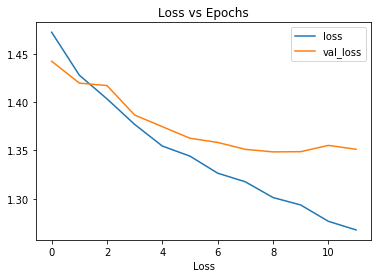

In [79]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.title('Loss vs Epochs')
plt.plot()


[]

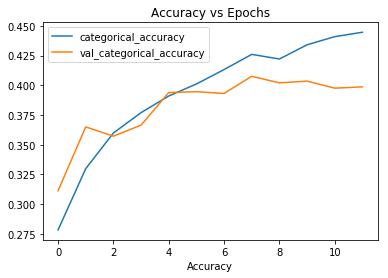

In [80]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.xlabel('Epochs')
plt.xlabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])
plt.plot()


#### Evaluate our test set and find out Cohen's  quadratic weighted kappa for both Train and Test

In [33]:
model.evaluate(X_test, y_test)

2999/2999 [==============================] - 73s 24ms/step


[1.5944053038790766, 0.36378792935945703]

In [76]:
test_pred = model.predict(X_test)
kappa(y_test, test_pred)

0.2743254292722812

In [77]:
train_pred = model.predict(X_train)
kappa(y_train, train_pred)

0.4001840130052027

#### Load out best model and check metrics

In [78]:
model.load_weights('../checkpoints/weights_image_text_categorical.hdf6')

test_pred = model.predict(X_test)
kappa(y_test, test_pred)

In [119]:
train_pred = model.predict(X_train)
kappa(y_train, train_pred)

0.44229078933665955